<ipython-input-1-cc56e0dfb6e3>:107: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = spsolve(A_reg, F_reg)


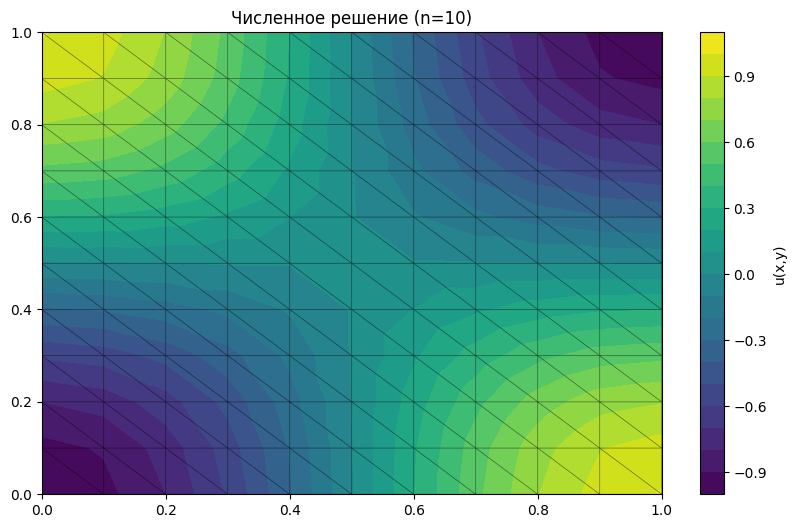

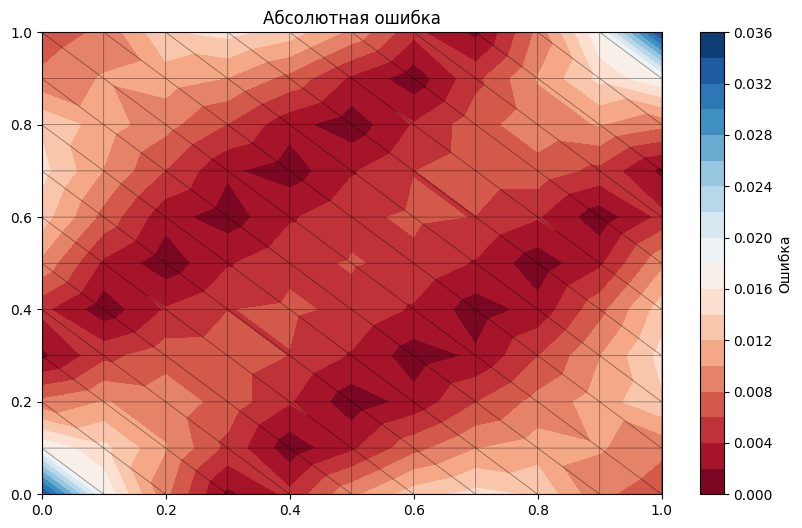

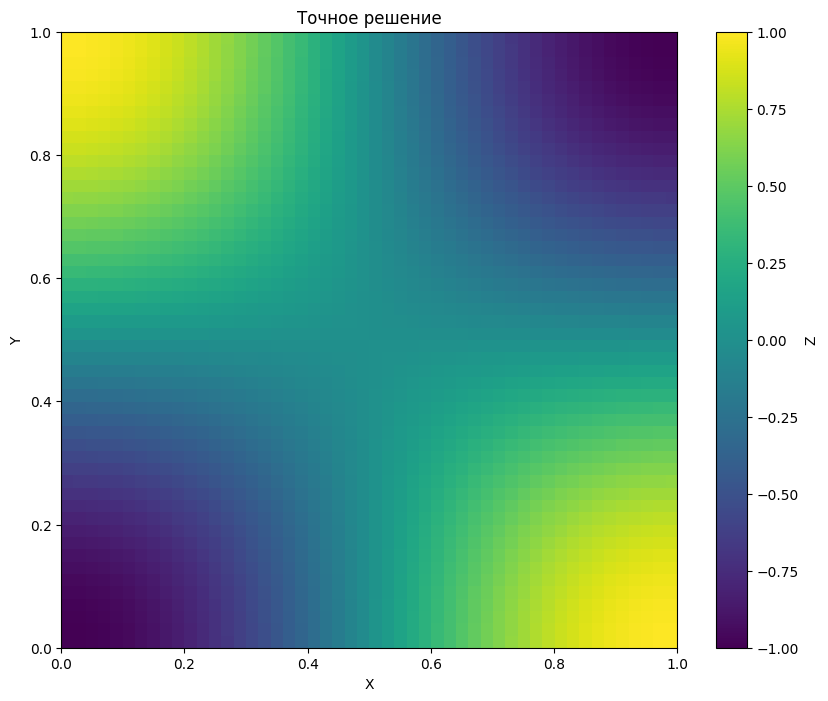

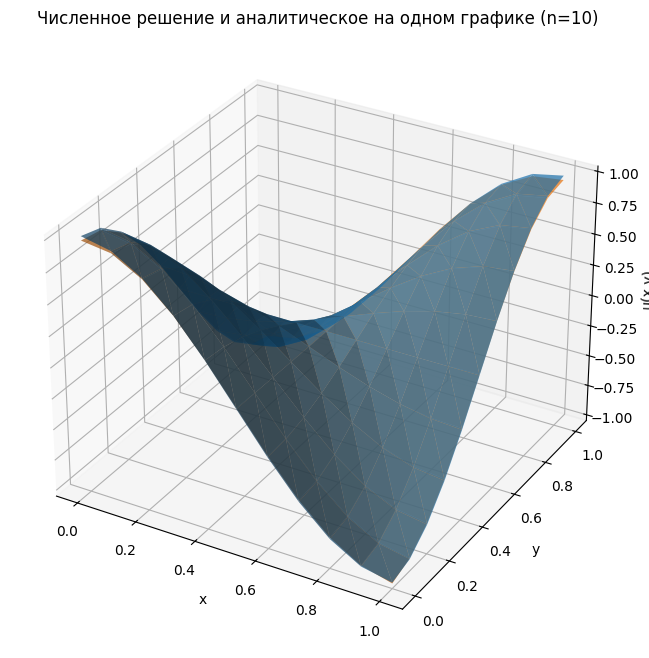

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def solve_poisson_neumann(n, f_func):
    # Параметры сетки
    h = 1 / n
    nodes = [(i * h, j * h) for i in range(n+1) for j in range(n+1)]
    num_nodes = len(nodes)
    A = lil_matrix((num_nodes, num_nodes))
    F = np.zeros(num_nodes)

    # Построение матрицы A и вектора F
    for i in range(n):
        for j in range(n):
            # Треугольник 1: (i,j), (i+1,j), (i,j+1)
            nodes_T = [
                (i*h, j*h),
                ((i+1)*h, j*h),
                (i*h, (j+1)*h)
            ]
            indices = [i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1]

            # Локальная матрица жесткости
            x1, y1 = nodes_T[0]
            x2, y2 = nodes_T[1]
            x3, y3 = nodes_T[2]
            area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

            grad_phi1 = np.array([y2 - y3, x3 - x2]) / (2 * area)
            grad_phi2 = np.array([y3 - y1, x1 - x3]) / (2 * area)
            grad_phi3 = np.array([y1 - y2, x2 - x1]) / (2 * area)

            A_local = np.zeros((3, 3))
            A_local[0, 0] = np.dot(grad_phi1, grad_phi1) * area
            A_local[0, 1] = np.dot(grad_phi1, grad_phi2) * area
            A_local[0, 2] = np.dot(grad_phi1, grad_phi3) * area
            A_local[1, 1] = np.dot(grad_phi2, grad_phi2) * area
            A_local[1, 2] = np.dot(grad_phi2, grad_phi3) * area
            A_local[2, 2] = np.dot(grad_phi3, grad_phi3) * area
            A_local[1, 0] = A_local[0, 1]
            A_local[2, 0] = A_local[0, 2]
            A_local[2, 1] = A_local[1, 2]

            for k in range(3):
                for m in range(3):
                    A[indices[k], indices[m]] += A_local[k, m]

            # Вектор нагрузки
            x_centroid = (x1 + x2 + x3) / 3
            y_centroid = (y1 + y2 + y3) / 3
            F_local = area * f_func(x_centroid, y_centroid) * np.array([1/3, 1/3, 1/3])
            for k in range(3):
                F[indices[k]] += F_local[k]

            # Треугольник 2: ((i+1,j), (i+1,j+1), (i,j+1)
            nodes_T = [
                ((i+1)*h, j*h),
                ((i+1)*h, (j+1)*h),
                (i*h, (j+1)*h)
            ]
            indices = [(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1]

            # Повторяем вычисления для второго треугольника
            x1, y1 = nodes_T[0]
            x2, y2 = nodes_T[1]
            x3, y3 = nodes_T[2]
            area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

            grad_phi1 = np.array([y2 - y3, x3 - x2]) / (2 * area)
            grad_phi2 = np.array([y3 - y1, x1 - x3]) / (2 * area)
            grad_phi3 = np.array([y1 - y2, x2 - x1]) / (2 * area)

            A_local = np.zeros((3, 3))
            A_local[0, 0] = np.dot(grad_phi1, grad_phi1) * area
            A_local[0, 1] = np.dot(grad_phi1, grad_phi2) * area
            A_local[0, 2] = np.dot(grad_phi1, grad_phi3) * area
            A_local[1, 1] = np.dot(grad_phi2, grad_phi2) * area
            A_local[1, 2] = np.dot(grad_phi2, grad_phi3) * area
            A_local[2, 2] = np.dot(grad_phi3, grad_phi3) * area
            A_local[1, 0] = A_local[0, 1]
            A_local[2, 0] = A_local[0, 2]
            A_local[2, 1] = A_local[1, 2]

            for k in range(3):
                for m in range(3):
                    A[indices[k], indices[m]] += A_local[k, m]

            x_centroid = (x1 + x2 + x3) / 3
            y_centroid = (y1 + y2 + y3) / 3
            F_local = area * f_func(x_centroid, y_centroid) * np.array([1/3, 1/3, 1/3])
            for k in range(3):
                F[indices[k]] += F_local[k]

    # Регуляризация
    A = A.tocsr()
    A_dense = A.toarray()
    ones_row = np.ones(num_nodes)
    A_reg = np.vstack([A_dense, ones_row])
    ones_col = np.hstack([ones_row, 0]).reshape(-1, 1)
    A_reg = np.hstack([A_reg, ones_col])
    F_reg = np.hstack([F, 0])

    # Решение системы
    u = spsolve(A_reg, F_reg)
    u = u[:-1]

    return u, nodes

# Функция f(x, y) (пример)
def f(x, y):
    return -2 * np.pi**2 * np.cos(np.pi * x) * np.cos(np.pi * y)

# Параметры
n = 10
u, nodes = solve_poisson_neumann(n, f)

# Визуализация
x_coords = np.array([node[0] for node in nodes])
y_coords = np.array([node[1] for node in nodes])
triangles = []
for i in range(n):
    for j in range(n):
        triangles.append([i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1])
        triangles.append([(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1])

triang = tri.Triangulation(x_coords, y_coords, triangles)

plt.figure(figsize=(10, 6))
plt.tricontourf(triang, u, levels=20, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.title(f'Численное решение (n={n})')
plt.triplot(triang, color='black', linewidth=0.5, alpha=0.5)
plt.show()

u_analytic = -np.cos(np.pi * x_coords) * np.cos(np.pi * y_coords)
error = abs(u - u_analytic)

plt.figure(figsize=(10, 6))
plt.tricontourf(triang, error, levels=20, cmap='RdBu')
plt.colorbar(label='Ошибка')
plt.title('Абсолютная ошибка')
plt.triplot(triang, color='black', linewidth=0.5, alpha=0.5)
plt.show()

x,y = np.mgrid[0:1:50j,0:1:50j]
plt.figure(figsize=(10, 8))
z_1 = np.cos(np.pi*x)*np.cos(np.pi*y)
plt.title('Точное решение')
plt.imshow(z_1, extent=[0, 1, 0, 1])
plt.colorbar(label='Z')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# 3D-график
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
u_analytic = np.cos(np.pi * x_coords) * np.cos(np.pi * y_coords)
ax.plot_trisurf(x_coords, y_coords, u_analytic, triangles=triang.triangles, alpha = 0.7)
ax.plot_trisurf(x_coords, y_coords, -u, triangles=triang.triangles, alpha = 0.7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
plt.title(f'Численное решение и аналитическое на одном графике (n={n})')
plt.show()


<ipython-input-28-49cd620cfbda>:107: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = spsolve(A_reg, F_reg)


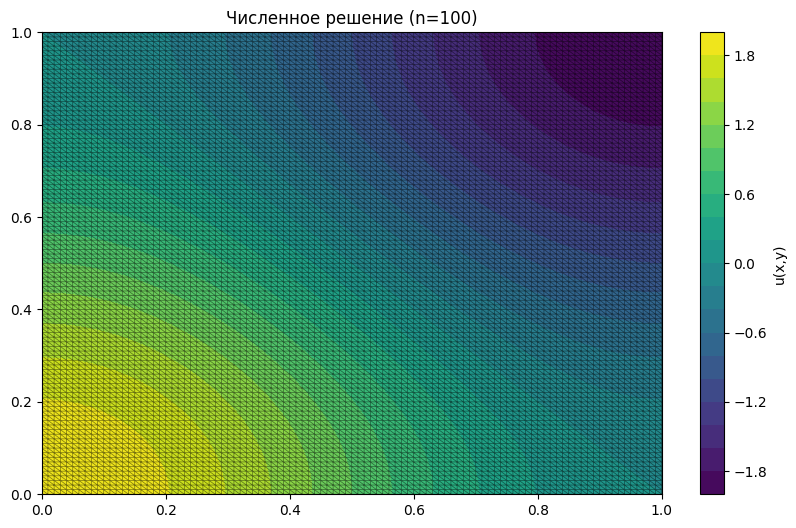

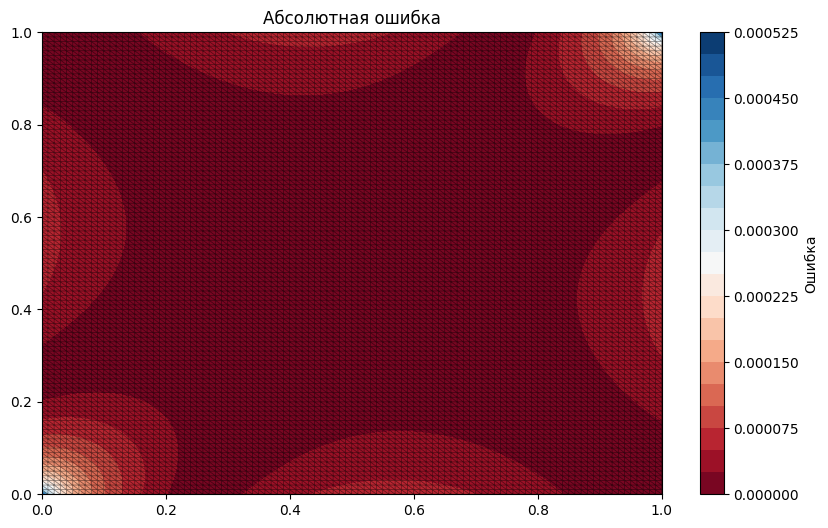

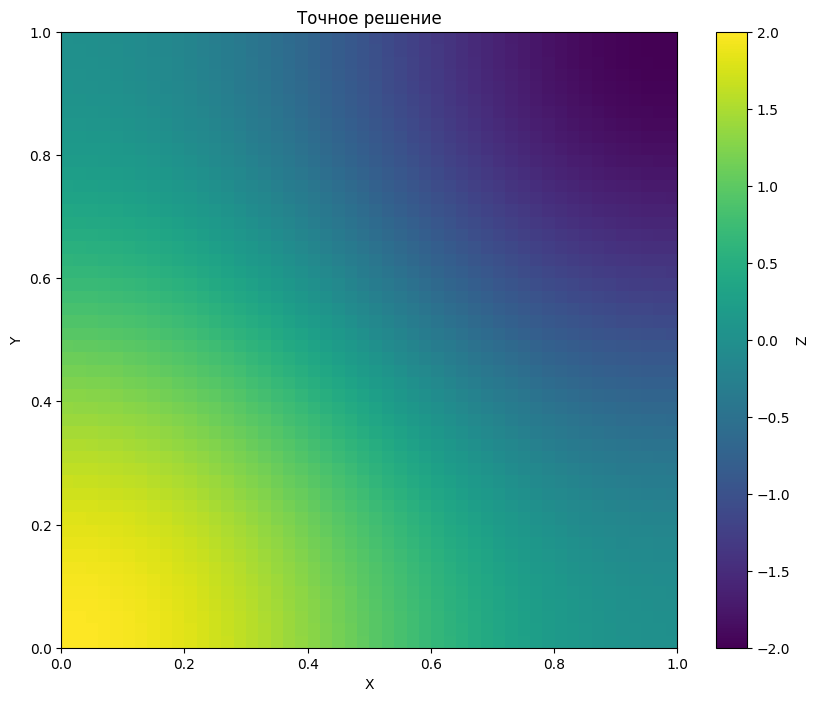

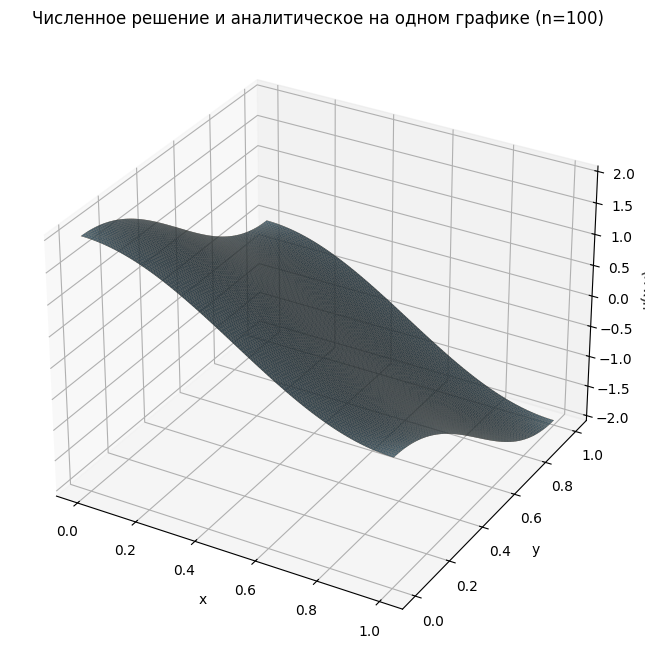

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def solve_poisson_neumann(n, f_func):
    # Параметры сетки
    h = 1 / n
    nodes = [(i * h, j * h) for i in range(n+1) for j in range(n+1)]
    num_nodes = len(nodes)
    A = lil_matrix((num_nodes, num_nodes))
    F = np.zeros(num_nodes)

    # Построение матрицы A и вектора F
    for i in range(n):
        for j in range(n):
            # Треугольник 1: (i,j), (i+1,j), (i,j+1)
            nodes_T = [
                (i*h, j*h),
                ((i+1)*h, j*h),
                (i*h, (j+1)*h)
            ]
            indices = [i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1]

            # Локальная матрица жесткости
            x1, y1 = nodes_T[0]
            x2, y2 = nodes_T[1]
            x3, y3 = nodes_T[2]
            area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

            grad_phi1 = np.array([y2 - y3, x3 - x2]) / (2 * area)
            grad_phi2 = np.array([y3 - y1, x1 - x3]) / (2 * area)
            grad_phi3 = np.array([y1 - y2, x2 - x1]) / (2 * area)

            A_local = np.zeros((3, 3))
            A_local[0, 0] = np.dot(grad_phi1, grad_phi1) * area
            A_local[0, 1] = np.dot(grad_phi1, grad_phi2) * area
            A_local[0, 2] = np.dot(grad_phi1, grad_phi3) * area
            A_local[1, 1] = np.dot(grad_phi2, grad_phi2) * area
            A_local[1, 2] = np.dot(grad_phi2, grad_phi3) * area
            A_local[2, 2] = np.dot(grad_phi3, grad_phi3) * area
            A_local[1, 0] = A_local[0, 1]
            A_local[2, 0] = A_local[0, 2]
            A_local[2, 1] = A_local[1, 2]

            for k in range(3):
                for m in range(3):
                    A[indices[k], indices[m]] += A_local[k, m]

            # Вектор нагрузки
            x_centroid = (x1 + x2 + x3) / 3
            y_centroid = (y1 + y2 + y3) / 3
            F_local = area * f_func(x_centroid, y_centroid) * np.array([1/3, 1/3, 1/3])
            for k in range(3):
                F[indices[k]] += F_local[k]

            # Треугольник 2: ((i+1,j), (i+1,j+1), (i,j+1)
            nodes_T = [
                ((i+1)*h, j*h),
                ((i+1)*h, (j+1)*h),
                (i*h, (j+1)*h)
            ]
            indices = [(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1]

            # Повторяем вычисления для второго треугольника
            x1, y1 = nodes_T[0]
            x2, y2 = nodes_T[1]
            x3, y3 = nodes_T[2]
            area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

            grad_phi1 = np.array([y2 - y3, x3 - x2]) / (2 * area)
            grad_phi2 = np.array([y3 - y1, x1 - x3]) / (2 * area)
            grad_phi3 = np.array([y1 - y2, x2 - x1]) / (2 * area)

            A_local = np.zeros((3, 3))
            A_local[0, 0] = np.dot(grad_phi1, grad_phi1) * area
            A_local[0, 1] = np.dot(grad_phi1, grad_phi2) * area
            A_local[0, 2] = np.dot(grad_phi1, grad_phi3) * area
            A_local[1, 1] = np.dot(grad_phi2, grad_phi2) * area
            A_local[1, 2] = np.dot(grad_phi2, grad_phi3) * area
            A_local[2, 2] = np.dot(grad_phi3, grad_phi3) * area
            A_local[1, 0] = A_local[0, 1]
            A_local[2, 0] = A_local[0, 2]
            A_local[2, 1] = A_local[1, 2]

            for k in range(3):
                for m in range(3):
                    A[indices[k], indices[m]] += A_local[k, m]

            x_centroid = (x1 + x2 + x3) / 3
            y_centroid = (y1 + y2 + y3) / 3
            F_local = area * f_func(x_centroid, y_centroid) * np.array([1/3, 1/3, 1/3])
            for k in range(3):
                F[indices[k]] += F_local[k]

    # Регуляризация
    A = A.tocsr()
    A_dense = A.toarray()
    ones_row = np.ones(num_nodes)
    A_reg = np.vstack([A_dense, ones_row])
    ones_col = np.hstack([ones_row, 0]).reshape(-1, 1)
    A_reg = np.hstack([A_reg, ones_col])
    F_reg = np.hstack([F, 0])

    # Решение системы
    u = spsolve(A_reg, F_reg)
    u = u[:-1]

    return u, nodes

# Функция f(x, y) (пример)
def f(x, y):
    return ((np.pi)**2)*(np.cos(np.pi * x) + np.cos(np.pi * y))

# Параметры
n = 100
u, nodes = solve_poisson_neumann(n, f)

# Визуализация
x_coords = np.array([node[0] for node in nodes])
y_coords = np.array([node[1] for node in nodes])
triangles = []
for i in range(n):
    for j in range(n):
        triangles.append([i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1])
        triangles.append([(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1])

triang = tri.Triangulation(x_coords, y_coords, triangles)

plt.figure(figsize=(10, 6))
plt.tricontourf(triang, u, levels=20, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.title(f'Численное решение (n={n})')
plt.triplot(triang, color='black', linewidth=0.5, alpha=0.5)
plt.show()

u_analytic = np.cos(np.pi*x_coords) + np.cos(np.pi*y_coords)
error = abs(u - u_analytic)

plt.figure(figsize=(10, 6))
plt.tricontourf(triang, error, levels=20, cmap='RdBu')
plt.colorbar(label='Ошибка')
plt.title('Абсолютная ошибка')
plt.triplot(triang, color='black', linewidth=0.5, alpha=0.5)
plt.show()

x,y = np.mgrid[0:1:50j,0:1:50j]
plt.figure(figsize=(10, 8))
z_1 = -np.cos(np.pi*x) + np.cos(np.pi*y)
plt.title('Точное решение')
plt.imshow(z_1, extent=[0, 1, 0, 1])
plt.colorbar(label='Z')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# 3D-график
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
u_analytic = np.cos(np.pi*x_coords) + np.cos(np.pi*y_coords)
ax.plot_trisurf(x_coords, y_coords, u_analytic, triangles=triang.triangles, alpha = 0.7)
ax.plot_trisurf(x_coords, y_coords, u, triangles=triang.triangles,  alpha = 0.7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
plt.title(f'Численное решение и аналитическое на одном графике (n={n})')
plt.show()

<ipython-input-31-78efecf1a0fd>:107: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = spsolve(A_reg, F_reg)


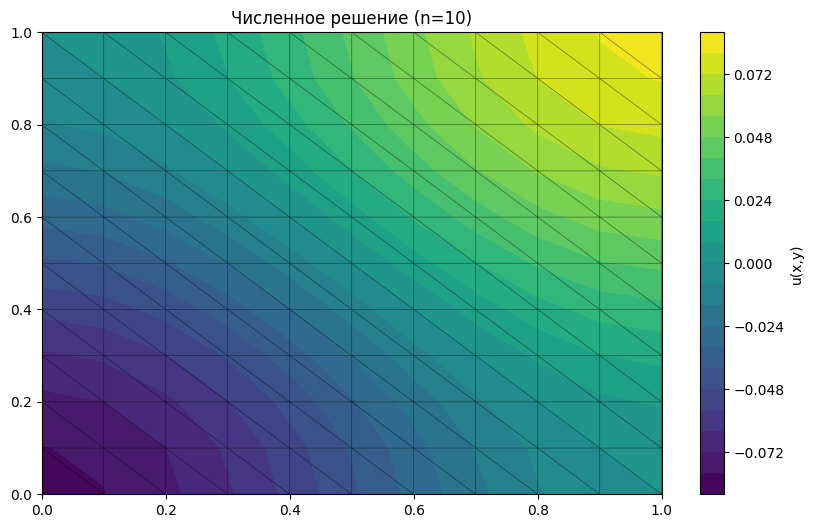

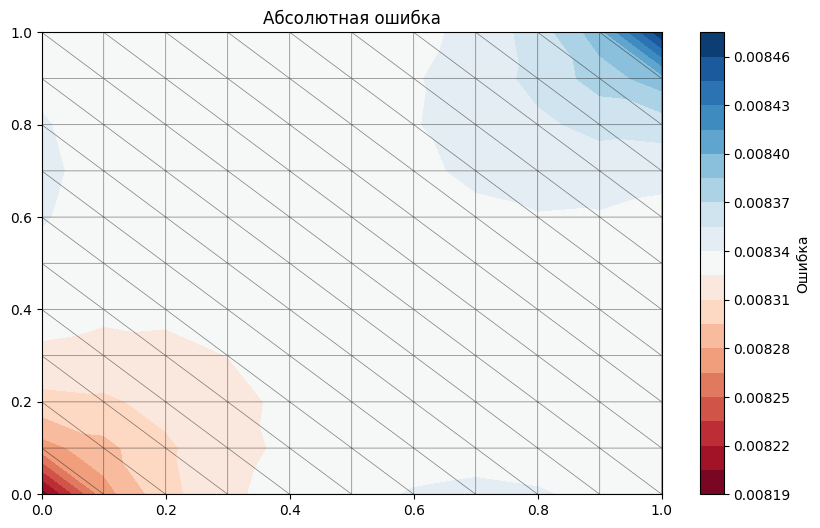

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def solve_poisson_neumann(n, f_func):
    # Параметры сетки
    h = 1 / n
    nodes = [(i * h, j * h) for i in range(n+1) for j in range(n+1)]
    num_nodes = len(nodes)
    A = lil_matrix((num_nodes, num_nodes))
    F = np.zeros(num_nodes)

    # Построение матрицы A и вектора F
    for i in range(n):
        for j in range(n):
            # Треугольник 1: (i,j), (i+1,j), (i,j+1)
            nodes_T = [
                (i*h, j*h),
                ((i+1)*h, j*h),
                (i*h, (j+1)*h)
            ]
            indices = [i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1]

            # Локальная матрица жесткости
            x1, y1 = nodes_T[0]
            x2, y2 = nodes_T[1]
            x3, y3 = nodes_T[2]
            area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

            grad_phi1 = np.array([y2 - y3, x3 - x2]) / (2 * area)
            grad_phi2 = np.array([y3 - y1, x1 - x3]) / (2 * area)
            grad_phi3 = np.array([y1 - y2, x2 - x1]) / (2 * area)

            A_local = np.zeros((3, 3))
            A_local[0, 0] = np.dot(grad_phi1, grad_phi1) * area
            A_local[0, 1] = np.dot(grad_phi1, grad_phi2) * area
            A_local[0, 2] = np.dot(grad_phi1, grad_phi3) * area
            A_local[1, 1] = np.dot(grad_phi2, grad_phi2) * area
            A_local[1, 2] = np.dot(grad_phi2, grad_phi3) * area
            A_local[2, 2] = np.dot(grad_phi3, grad_phi3) * area
            A_local[1, 0] = A_local[0, 1]
            A_local[2, 0] = A_local[0, 2]
            A_local[2, 1] = A_local[1, 2]

            for k in range(3):
                for m in range(3):
                    A[indices[k], indices[m]] += A_local[k, m]

            # Вектор нагрузки
            x_centroid = (x1 + x2 + x3) / 3
            y_centroid = (y1 + y2 + y3) / 3
            F_local = area * f_func(x_centroid, y_centroid) * np.array([1/3, 1/3, 1/3])
            for k in range(3):
                F[indices[k]] += F_local[k]

            # Треугольник 2: ((i+1,j), (i+1,j+1), (i,j+1)
            nodes_T = [
                ((i+1)*h, j*h),
                ((i+1)*h, (j+1)*h),
                (i*h, (j+1)*h)
            ]
            indices = [(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1]

            # Повторяем вычисления для второго треугольника
            x1, y1 = nodes_T[0]
            x2, y2 = nodes_T[1]
            x3, y3 = nodes_T[2]
            area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

            grad_phi1 = np.array([y2 - y3, x3 - x2]) / (2 * area)
            grad_phi2 = np.array([y3 - y1, x1 - x3]) / (2 * area)
            grad_phi3 = np.array([y1 - y2, x2 - x1]) / (2 * area)

            A_local = np.zeros((3, 3))
            A_local[0, 0] = np.dot(grad_phi1, grad_phi1) * area
            A_local[0, 1] = np.dot(grad_phi1, grad_phi2) * area
            A_local[0, 2] = np.dot(grad_phi1, grad_phi3) * area
            A_local[1, 1] = np.dot(grad_phi2, grad_phi2) * area
            A_local[1, 2] = np.dot(grad_phi2, grad_phi3) * area
            A_local[2, 2] = np.dot(grad_phi3, grad_phi3) * area
            A_local[1, 0] = A_local[0, 1]
            A_local[2, 0] = A_local[0, 2]
            A_local[2, 1] = A_local[1, 2]

            for k in range(3):
                for m in range(3):
                    A[indices[k], indices[m]] += A_local[k, m]

            x_centroid = (x1 + x2 + x3) / 3
            y_centroid = (y1 + y2 + y3) / 3
            F_local = area * f_func(x_centroid, y_centroid) * np.array([1/3, 1/3, 1/3])
            for k in range(3):
                F[indices[k]] += F_local[k]

    # Регуляризация
    A = A.tocsr()
    A_dense = A.toarray()
    ones_row = np.ones(num_nodes)
    A_reg = np.vstack([A_dense, ones_row])
    ones_col = np.hstack([ones_row, 0]).reshape(-1, 1)
    A_reg = np.hstack([A_reg, ones_col])
    F_reg = np.hstack([F, 0])

    # Решение системы
    u = spsolve(A_reg, F_reg)
    u = u[:-1]

    return u, nodes

# Функция f(x, y) (пример)
def f(x, y):
    return x + y - 1

# Параметры
n = 10  # Можно задать любое n > 1
u, nodes = solve_poisson_neumann(n, f)

# Визуализация
x_coords = np.array([node[0] for node in nodes])
y_coords = np.array([node[1] for node in nodes])
triangles = []
for i in range(n):
    for j in range(n):
        triangles.append([i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1])
        triangles.append([(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1])

triang = tri.Triangulation(x_coords, y_coords, triangles)

plt.figure(figsize=(10, 6))
plt.tricontourf(triang, u, levels=20, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.title(f'Численное решение (n={n})')
plt.triplot(triang, color='black', linewidth=0.5, alpha=0.5)
plt.show()

u_analytic = -(x_coords**3)/6 + (x_coords**2)/4 -(y_coords**3)/6 +(y_coords**2)/4
error = abs(u - u_analytic)/10

plt.figure(figsize=(10, 6))
plt.tricontourf(triang, error, levels=20, cmap='RdBu')
plt.colorbar(label='Ошибка')
plt.title('Абсолютная ошибка')
plt.triplot(triang, color='black', linewidth=0.5, alpha=0.5)
plt.show()



<ipython-input-57-5619cd9c1592>:122: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = spsolve(A_reg, F_reg) if epsilon == 0 else spsolve(A, F)


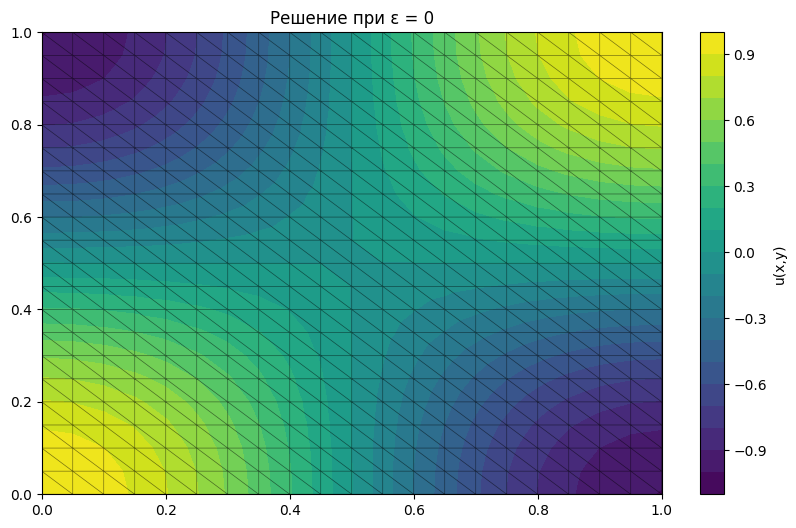

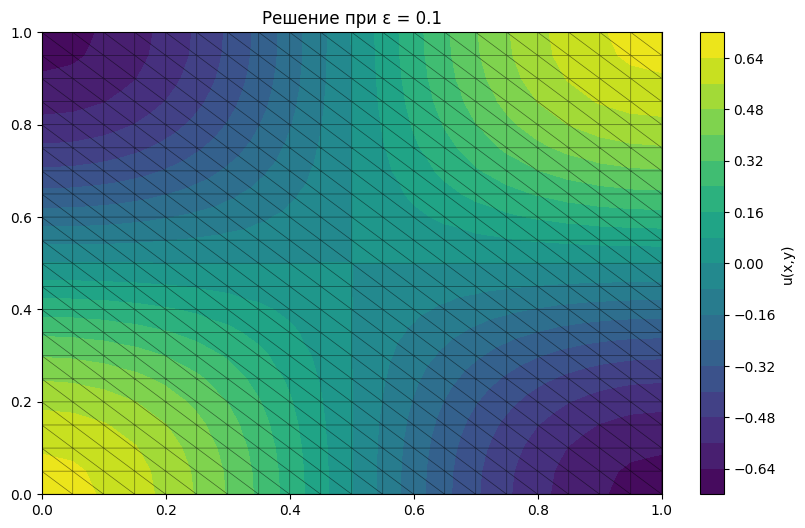

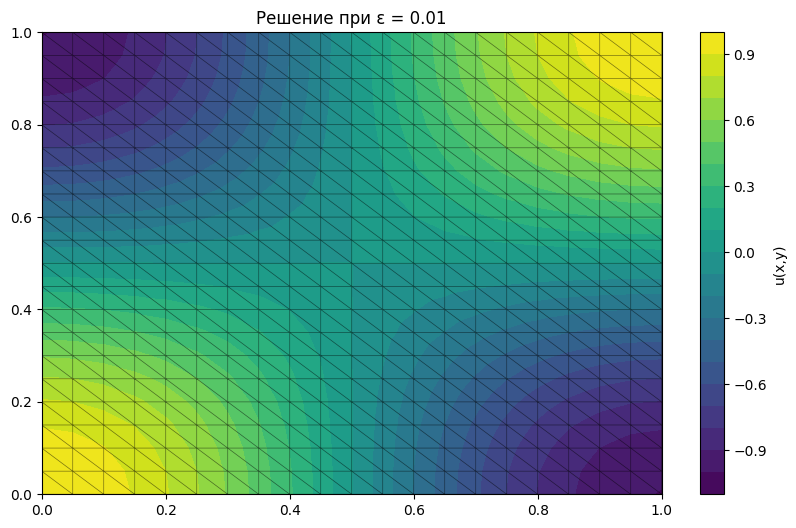

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def solve_modified_poisson(n, f_func, epsilon=0):
    # Параметры сетки
    h = 1 / n
    nodes = [(i * h, j * h) for i in range(n+1) for j in range(n+1)]
    num_nodes = len(nodes)
    A = lil_matrix((num_nodes, num_nodes))
    F = np.zeros(num_nodes)

    # Построение матрицы A и вектора F
    for i in range(n):
        for j in range(n):
            # Треугольник 1: (i,j), (i+1,j), (i,j+1)
            nodes_T = [
                (i*h, j*h),
                ((i+1)*h, j*h),
                (i*h, (j+1)*h)
            ]
            indices = [i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1]

            # Площадь треугольника
            x1, y1 = nodes_T[0]
            x2, y2 = nodes_T[1]
            x3, y3 = nodes_T[2]
            area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

            # Локальная матрица жесткости
            grad_phi1 = np.array([y2 - y3, x3 - x2]) / (2 * area)
            grad_phi2 = np.array([y3 - y1, x1 - x3]) / (2 * area)
            grad_phi3 = np.array([y1 - y2, x2 - x1]) / (2 * area)

            A_stiffness = np.zeros((3, 3))
            A_stiffness[0, 0] = np.dot(grad_phi1, grad_phi1) * area
            A_stiffness[0, 1] = np.dot(grad_phi1, grad_phi2) * area
            A_stiffness[0, 2] = np.dot(grad_phi1, grad_phi3) * area
            A_stiffness[1, 1] = np.dot(grad_phi2, grad_phi2) * area
            A_stiffness[1, 2] = np.dot(grad_phi2, grad_phi3) * area
            A_stiffness[2, 2] = np.dot(grad_phi3, grad_phi3) * area
            A_stiffness[1, 0] = A_stiffness[0, 1]
            A_stiffness[2, 0] = A_stiffness[0, 2]
            A_stiffness[2, 1] = A_stiffness[1, 2]

            # Локальная матрица массы
            A_mass = (area / 12) * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])

            # Суммируем жесткость и массу
            A_local = A_stiffness + epsilon * A_mass

            # Добавление в глобальную матрицу
            for k in range(3):
                for m in range(3):
                    A[indices[k], indices[m]] += A_local[k, m]

            # Вектор нагрузки
            x_centroid = (x1 + x2 + x3) / 3
            y_centroid = (y1 + y2 + y3) / 3
            F_local = area * f_func(x_centroid, y_centroid) * np.array([1/3, 1/3, 1/3])
            for k in range(3):
                F[indices[k]] += F_local[k]

            # Треугольник 2: ((i+1,j), (i+1,j+1), (i,j+1))
            nodes_T = [
                ((i+1)*h, j*h),
                ((i+1)*h, (j+1)*h),
                (i*h, (j+1)*h)
            ]
            indices = [(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1]

            # Повторяем вычисления для второго треугольника
            x1, y1 = nodes_T[0]
            x2, y2 = nodes_T[1]
            x3, y3 = nodes_T[2]
            area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

            grad_phi1 = np.array([y2 - y3, x3 - x2]) / (2 * area)
            grad_phi2 = np.array([y3 - y1, x1 - x3]) / (2 * area)
            grad_phi3 = np.array([y1 - y2, x2 - x1]) / (2 * area)

            A_stiffness = np.zeros((3, 3))
            A_stiffness[0, 0] = np.dot(grad_phi1, grad_phi1) * area
            A_stiffness[0, 1] = np.dot(grad_phi1, grad_phi2) * area
            A_stiffness[0, 2] = np.dot(grad_phi1, grad_phi3) * area
            A_stiffness[1, 1] = np.dot(grad_phi2, grad_phi2) * area
            A_stiffness[1, 2] = np.dot(grad_phi2, grad_phi3) * area
            A_stiffness[2, 2] = np.dot(grad_phi3, grad_phi3) * area
            A_stiffness[1, 0] = A_stiffness[0, 1]
            A_stiffness[2, 0] = A_stiffness[0, 2]
            A_stiffness[2, 1] = A_stiffness[1, 2]

            A_mass = (area / 12) * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])
            A_local = A_stiffness + epsilon * A_mass

            for k in range(3):
                for m in range(3):
                    A[indices[k], indices[m]] += A_local[k, m]

            x_centroid = (x1 + x2 + x3) / 3
            y_centroid = (y1 + y2 + y3) / 3
            F_local = area * f_func(x_centroid, y_centroid) * np.array([1/3, 1/3, 1/3])
            for k in range(3):
                F[indices[k]] += F_local[k]

    # Регуляризация (только при ε = 0)
    if epsilon == 0:
        A = A.tocsr()
        A_dense = A.toarray()
        ones_row = np.ones(num_nodes)
        A_reg = np.vstack([A_dense, ones_row])
        ones_col = np.hstack([ones_row, 0]).reshape(-1, 1)
        A_reg = np.hstack([A_reg, ones_col])
        F_reg = np.hstack([F, 0])
    else:
        A_reg = A.toarray()
        F_reg = F.copy()

    # Решение системы
    u = spsolve(A_reg, F_reg) if epsilon == 0 else spsolve(A, F)

    return u[:-1] if epsilon == 0 else u, nodes


n = 20
epsilon = 0
def f(x, y):
    return 2 * np.pi**2 * np.cos(np.pi * x) * np.cos(np.pi * y) + epsilon * np.cos(np.pi * x) * np.cos(np.pi * y)

u, nodes = solve_modified_poisson(n, f, epsilon)

# Визуализация
x_coords = np.array([node[0] for node in nodes])
y_coords = np.array([node[1] for node in nodes])
triangles = []
for i in range(n):
    for j in range(n):
        triangles.append([i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1])
        triangles.append([(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1])

triang = tri.Triangulation(x_coords, y_coords, triangles)

plt.figure(figsize=(10, 6))
plt.tricontourf(triang, u, levels=20, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.title(f'Решение при ε = {epsilon}')
plt.triplot(triang, color='black', linewidth=0.5, alpha=0.5)
plt.show()



epsilon = 0.1
u, nodes = solve_modified_poisson(n, f, 1/epsilon)

# Визуализация
x_coords = np.array([node[0] for node in nodes])
y_coords = np.array([node[1] for node in nodes])
triangles = []
for i in range(n):
    for j in range(n):
        triangles.append([i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1])
        triangles.append([(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1])

triang = tri.Triangulation(x_coords, y_coords, triangles)

plt.figure(figsize=(10, 6))
plt.tricontourf(triang, u, levels=20, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.title(f'Решение при ε = {epsilon}')
plt.triplot(triang, color='black', linewidth=0.5, alpha=0.5)
plt.show()


epsilon = 10
u, nodes = solve_modified_poisson(n, f, epsilon)

# Визуализация
x_coords = np.array([node[0] for node in nodes])
y_coords = np.array([node[1] for node in nodes])
triangles = []
for i in range(n):
    for j in range(n):
        triangles.append([i*(n+1)+j, (i+1)*(n+1)+j, i*(n+1)+j+1])
        triangles.append([(i+1)*(n+1)+j, (i+1)*(n+1)+j+1, i*(n+1)+j+1])

triang = tri.Triangulation(x_coords, y_coords, triangles)

plt.figure(figsize=(10, 6))
plt.tricontourf(triang, u, levels=20, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.title(f'Решение при ε = 0.01')
plt.triplot(triang, color='black', linewidth=0.5, alpha=0.5)
plt.show()